#### Importing all the required necessary libraries to be used for the analysis of restaurants in Bangalore

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import folium
from pandas.io.json import json_normalize

In [2]:
CLIENT_ID = 'SRA0SXOMEF1G1MS23CPICU3VELBP252FIEWV4P0UFPEAZVOM'
CLIENT_SECRET = 'XAMFNVOIRV43A0SWN5Y4YZGVFOR3EUUI5HBQPJWPO2XBC31H'
VERSION = '20180605'
LIMIT = 100
radius = 9000

In [3]:
lat = 12.9716
lng = 77.5946

In [4]:
blr_map = folium.Map(location = [lat, lng], zoom_start = 12)
folium.Marker([lat, lng]).add_to(blr_map)
blr_map

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

In [7]:
results = requests.get(url).json()

In [8]:
fvenues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

no_of_venues = len(results['response']['groups'][0]['items'])

print("{} Venues fetched within a radius of {} Km".format(no_of_venues, radius/1000))


venues = results['response']['groups'][0]['items']
venues = pd.json_normalize(venues)


filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]


venues['venue.categories'] = venues.apply(get_category_type, axis = 1)


#Dropping the prefix "venue" from each column
venues.columns = [col.split(".")[-1] for col in venues.columns]


fvenues = pd.concat([fvenues, venues], axis = 0, sort = False)


fvenues = fvenues.reset_index(drop = True)
fvenues.rename(columns={"name": "Name", "categories": "Categories","lat":"Latitude","lng":"Longitude"},inplace=True)
fvenues

100 Venues fetched within a radius of 9.0 Km


,Name,Categories,Latitude,Longitude
0,JW Marriott Hotel Bengaluru,Hotel,12.972362,77.595051
1,UB City,Shopping Mall,12.971709,77.595905
2,Toscano,Italian Restaurant,12.971980,77.596066
3,Truffles - Ice & Spice,Burger Joint,12.971802,77.601031
4,Harima,Sushi Restaurant,12.967755,77.600073
...,...,...,...,...
95,Citi Nest Sports Centre,Athletics & Sports,12.974748,77.633040
96,Glen's Bakehouse,Bakery,12.979148,77.640635
97,"PVR Gold Class, Orion",Multiplex,13.010923,77.555010
98,Cake Walk,Bakery,12.933662,77.626846


In [9]:
headers = {'user-key': 'ae68601c44f538926334a549ae84aa41'}
venues_info = []

for index, row in fvenues.iterrows():
    
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['Name'], row['Latitude'], row['Longitude'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_info.append(venue)
    else:
        venues_info.append(np.zeros(7))
    
zvenues = pd.DataFrame(venues_info, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])
zvenues.rename(columns={"venue": "ZName"},inplace=True)
zvenues

,ZName,latitude,longitude,price_for_two,price_range,rating,address
0,Merak-JW Marriott Hotel,12.9723820000,77.5950510000,1200.0,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle..."
1,Shiro,12.9717578595,77.5959215686,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L..."
2,Toscano,12.9718728650,77.5963661447,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell..."
3,Truffles,12.9717686413,77.6011371240,900.0,2.0,4.6,"22, St. Marks Road, Bangalore"
4,Harima,12.9675362725,77.5999006256,2000.0,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,..."
...,...,...,...,...,...,...,...
95,Kanteen 038,12.9745042540,77.6332378015,200.0,1.0,3.4,"91/72, Citi Nest, 7th Cross, Eshwara Layout, I..."
96,Glen's Bakehouse,12.9789119479,77.6410540938,600.0,2.0,4.2,"297, 100 Feet Road, Indiranagar, Bangalore"
97,Cold Stone Creamery,13.0109272121,77.5549400970,400.0,1.0,3.7,"26/1, 2nd Level, Brigade Gateway, Dr Rajkumar ..."
98,Onesta,12.9335469655,77.6269792020,600.0,2.0,4.0,"562, 8th Main, Koramangala 4th Block, Bangalore"


In [10]:
blr_map = folium.Map(location = [lat, lng], zoom_start = 12)

for name, latitude, longitude in zip(fvenues['Name'], fvenues['Latitude'], fvenues['Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(blr_map)  

blr_map

In [11]:
fvenues['Latitude'] = fvenues['Latitude'].apply(lambda lat: round(float(lat), 4))
fvenues['Longitude'] = fvenues['Longitude'].apply(lambda lng: round(float(lng), 4))
zvenues['latitude'] = zvenues['latitude'].apply(lambda lat: round(float(lat), 4))
zvenues['longitude'] = zvenues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([fvenues, zvenues], axis = 1)
dataset['lat_diff'] = dataset['Latitude'] - dataset['latitude']
dataset['lng_diff'] = dataset['Longitude'] - dataset['longitude']

In [13]:
pd.set_option('display.max_rows', None)

In [14]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0005) & (abs(dataset['lng_diff']) <= 0.0005)].reset_index(drop = True)
selected_venues

,Name,Categories,Latitude,Longitude,ZName,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,JW Marriott Hotel Bengaluru,Hotel,12.9724,77.5951,Merak-JW Marriott Hotel,12.9724,77.5951,1200.0,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",0.0000,0.0000
1,UB City,Shopping Mall,12.9717,77.5959,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",-0.0001,0.0000
2,Toscano,Italian Restaurant,12.9720,77.5961,Toscano,12.9719,77.5964,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",0.0001,-0.0003
3,Truffles - Ice & Spice,Burger Joint,12.9718,77.6010,Truffles,12.9718,77.6011,900.0,2.0,4.6,"22, St. Marks Road, Bangalore",0.0000,-0.0001
4,Harima,Sushi Restaurant,12.9678,77.6001,Harima,12.9675,77.5999,2000.0,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,...",0.0003,0.0002
5,Smoke House Deli,Deli / Bodega,12.9717,77.5983,Smoke House Deli,12.9717,77.5983,1600.0,3.0,4.5,"52/ 53, Ground Floor, Lavelle Road, Bangalore",0.0000,0.0000
6,Shiro,Japanese Restaurant,12.9719,77.5962,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",0.0001,0.0003
7,Café Noir,French Restaurant,12.9720,77.5960,Cafe Noir,12.9721,77.5964,1500.0,3.0,4.3,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",-0.0001,-0.0004
8,The Biere Club,Brewery,12.9711,77.5977,The Biere Club,12.9712,77.5976,1500.0,3.0,4.4,"20/2, Vittal Mallya Road, Lavelle Road, Bangalore",-0.0001,0.0001
9,Corner House,Ice Cream Shop,12.9730,77.6000,Corner House Ice Cream,12.9732,77.6000,350.0,1.0,4.3,"4, Madras Bank Road, Lavelle Road, Bangalore",-0.0002,0.0000


In [15]:
selected_venues = selected_venues.drop([3, 10, 26, 30, 39, 40, 45, 55, 59, 61, 68, 71, 75, 76]).reset_index(drop = True)

In [16]:
selected_venues

,Name,Categories,Latitude,Longitude,ZName,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,JW Marriott Hotel Bengaluru,Hotel,12.9724,77.5951,Merak-JW Marriott Hotel,12.9724,77.5951,1200.0,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",0.0000,0.0000
1,UB City,Shopping Mall,12.9717,77.5959,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",-0.0001,0.0000
2,Toscano,Italian Restaurant,12.9720,77.5961,Toscano,12.9719,77.5964,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",0.0001,-0.0003
3,Harima,Sushi Restaurant,12.9678,77.6001,Harima,12.9675,77.5999,2000.0,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,...",0.0003,0.0002
4,Smoke House Deli,Deli / Bodega,12.9717,77.5983,Smoke House Deli,12.9717,77.5983,1600.0,3.0,4.5,"52/ 53, Ground Floor, Lavelle Road, Bangalore",0.0000,0.0000
5,Shiro,Japanese Restaurant,12.9719,77.5962,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",0.0001,0.0003
6,Café Noir,French Restaurant,12.9720,77.5960,Cafe Noir,12.9721,77.5964,1500.0,3.0,4.3,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",-0.0001,-0.0004
7,The Biere Club,Brewery,12.9711,77.5977,The Biere Club,12.9712,77.5976,1500.0,3.0,4.4,"20/2, Vittal Mallya Road, Lavelle Road, Bangalore",-0.0001,0.0001
8,Corner House,Ice Cream Shop,12.9730,77.6000,Corner House Ice Cream,12.9732,77.6000,350.0,1.0,4.3,"4, Madras Bank Road, Lavelle Road, Bangalore",-0.0002,0.0000
9,ITC Gardenia,Hotel,12.9670,77.5956,Fabelle Chocolate Boutique - ITC Gardenia,12.9671,77.5957,1250.0,3.0,4.3,"ITC Gardenia, 1, Ashok Nagar, Residency Road, ...",-0.0001,-0.0001


In [1]:
selected_venues.loc[0,'address']

NameError: name 'selected_venues' is not defined

In [17]:
features = selected_venues[['price_for_two','rating']]
features

,price_for_two,rating
0,1200.0,3.8
1,3000.0,4.2
2,2400.0,4.4
3,2000.0,4.4
4,1600.0,4.5
5,3000.0,4.2
6,1500.0,4.3
7,1500.0,4.4
8,350.0,4.3
9,1250.0,4.3


In [18]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [19]:
data = StandardScaler().fit_transform(features)
data

array([[ 0.25753395, -1.11799793],
       [ 2.36462988,  0.04938947],
       [ 1.66226457,  0.63308316],
       [ 1.19402103,  0.63308316],
       [ 0.72577749,  0.92493001],
       [ 2.36462988,  0.04938947],
       [ 0.6087166 ,  0.34123631],
       [ 0.6087166 ,  0.63308316],
       [-0.73748358,  0.34123631],
       [ 0.31606439,  0.34123631],
       [-0.56189225, -0.82615108],
       [ 1.77932545,  1.50862371],
       [-0.9130749 ,  0.04938947],
       [-0.67895313, -1.40984477],
       [ 0.37459483,  0.04938947],
       [ 0.6087166 , -0.24245738],
       [ 1.19402103,  0.04938947],
       [ 1.19402103,  0.34123631],
       [ 0.95989926, -0.24245738],
       [-0.44483136,  0.92493001],
       [ 0.25753395, -0.24245738],
       [ 0.72577749,  0.34123631],
       [-0.32777048, -0.82615108],
       [ 0.37459483,  0.34123631],
       [-0.73748358,  0.92493001],
       [ 2.71581254, -0.82615108],
       [-0.21070959, -0.24245738],
       [-0.97160535,  0.34123631],
       [ 2.36462988,

In [38]:
wcss=[]
for i in range(1,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)

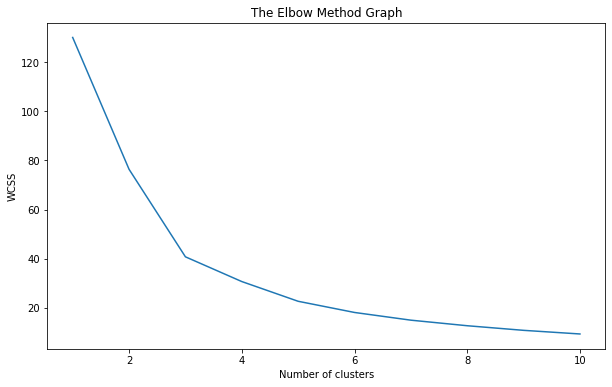

In [39]:
plt.figure(figsize=(10,6))
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
clustering_kmeans = KMeans(n_clusters=3)
model = clustering_kmeans.fit(data)
features['cluster'] = clustering_kmeans.fit_predict(data)

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
features = features.astype({"rating": float})
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_for_two  65 non-null     float64
 1   rating         65 non-null     float64
 2   cluster        65 non-null     int32  
dtypes: float64(2), int32(1)
memory usage: 1.4 KB


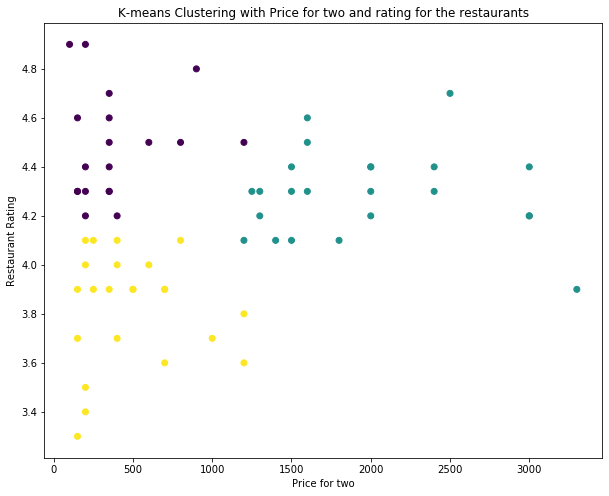

In [43]:

plt.figure(figsize=(10,8))

plt.scatter(features['price_for_two'], features['rating'], c=model.labels_.astype(float))
plt.title('K-means Clustering with Price for two and rating for the restaurants')
plt.xlabel("Price for two")
plt.ylabel("Restaurant Rating")
plt.show()

In [46]:
selected_venues['Clusters'] = features['cluster']
selected_venues

,Name,Categories,Latitude,Longitude,ZName,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff,Clusters
0,JW Marriott Hotel Bengaluru,Hotel,12.9724,77.5951,Merak-JW Marriott Hotel,12.9724,77.5951,1200.0,3.0,3.8,"JW Marriott, 24/1, Vittal Mallya Road, Lavelle...",0.0000,0.0000,2
1,UB City,Shopping Mall,12.9717,77.5959,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",-0.0001,0.0000,1
2,Toscano,Italian Restaurant,12.9720,77.5961,Toscano,12.9719,77.5964,2400.0,4.0,4.4,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",0.0001,-0.0003,1
3,Harima,Sushi Restaurant,12.9678,77.6001,Harima,12.9675,77.5999,2000.0,4.0,4.4,"131, 4th Floor, Devatha Plaza, Residency Road,...",0.0003,0.0002,1
4,Smoke House Deli,Deli / Bodega,12.9717,77.5983,Smoke House Deli,12.9717,77.5983,1600.0,3.0,4.5,"52/ 53, Ground Floor, Lavelle Road, Bangalore",0.0000,0.0000,1
5,Shiro,Japanese Restaurant,12.9719,77.5962,Shiro,12.9718,77.5959,3000.0,4.0,4.2,"2nd Floor, UB City Mall, Vittal Mallya Road, L...",0.0001,0.0003,1
6,Café Noir,French Restaurant,12.9720,77.5960,Cafe Noir,12.9721,77.5964,1500.0,3.0,4.3,"2nd Floor, UB City, Vittal Mallya Road, Lavell...",-0.0001,-0.0004,1
7,The Biere Club,Brewery,12.9711,77.5977,The Biere Club,12.9712,77.5976,1500.0,3.0,4.4,"20/2, Vittal Mallya Road, Lavelle Road, Bangalore",-0.0001,0.0001,1
8,Corner House,Ice Cream Shop,12.9730,77.6000,Corner House Ice Cream,12.9732,77.6000,350.0,1.0,4.3,"4, Madras Bank Road, Lavelle Road, Bangalore",-0.0002,0.0000,0
9,ITC Gardenia,Hotel,12.9670,77.5956,Fabelle Chocolate Boutique - ITC Gardenia,12.9671,77.5957,1250.0,3.0,4.3,"ITC Gardenia, 1, Ashok Nagar, Residency Road, ...",-0.0001,-0.0001,1


In [59]:
blr_map = folium.Map(location = [lat, lng], zoom_start = 12.5)
color_map = { 0: 'green', 1: 'red',2: 'blue'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['Name'], 
                                                        selected_venues['address'], 
                                                        selected_venues['Clusters'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 6,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(blr_map)


for index, cluster in enumerate(model.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 9,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(blr_map)


blr_map